In [1]:
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.utils import image_dataset_from_directory
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, Rescaling, Resizing
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomBrightness, RandomContrast
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

In [2]:
# 入力画像サイズ
img_width, img_height = 64, 64

# データセットのパス
train_data_dir = "./dataset/train"
test_data_dir = "./dataset/test"

# 学習回数
epoch = 1000

# 学習率
learning_rate = 0.01

# バッチサイズ
batch_size = 16

# クラス設定
classes = ["dog", "owl"]
nb_classes = len(classes)

In [3]:
### モデルの定義 ###
model = Sequential()

# 入力層
model.add(Input(shape=(img_height, img_width, 3)))

# データ拡張
model.add(RandomFlip())
model.add(RandomRotation(0.2))
model.add(RandomZoom(0.2, 0.2))
model.add(RandomTranslation(0.2, 0.2))
model.add(RandomBrightness(0.2))
model.add(RandomContrast(0.2))

# 正規化
model.add(Rescaling(1./255))

# 中間層
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# 出力層
model.add(Dense(nb_classes, activation='softmax'))

# モデルの確認
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 64, 64, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 64, 64, 3)      │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 64, 64, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,270,338 (16.29 MB)

 Trainable params: 4,270,338 (16.29 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# 誤差関数は多クラス交差エントロピー、最適化手法は勾配降下法
model.compile(
        loss='categorical_crossentropy',
        optimizer=SGD(learning_rate=learning_rate),
        metrics=['accuracy'])

In [5]:
# モデルの保存設定
mc_cb = ModelCheckpoint(
        filepath='./best_model.keras',
        monitor='val_loss',
        verbose=0,
        save_best_only=True)

In [6]:
# 学習データの読み込み
train_dataset = image_dataset_from_directory(
        train_data_dir,
        label_mode='categorical',
        class_names=classes,
        batch_size=batch_size,
        image_size=(img_height, img_width))

# テストデータの読み込み
test_dataset = image_dataset_from_directory(
        test_data_dir,
        label_mode='categorical',
        class_names=classes,
        batch_size=1,
        image_size=(img_height, img_width))

Found 182 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


In [7]:
# 学習
history = model.fit(
    train_dataset,
    epochs=epoch,
    validation_data=test_dataset,
    callbacks=[mc_cb])

Epoch 1/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5406 - loss: 0.7079 - val_accuracy: 0.5000 - val_loss: 0.7322
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5061 - loss: 0.7097 - val_accuracy: 0.5250 - val_loss: 0.6820
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4718 - loss: 0.7163 - val_accuracy: 0.7000 - val_loss: 0.6617
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5117 - loss: 0.6981 - val_accuracy: 0.7500 - val_loss: 0.6572
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5561 - loss: 0.6886 - val_accuracy: 0.7000 - val_loss: 0.6458
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6127 - loss: 0.6795 - val_accuracy: 0.7750 - val_loss: 0.6397
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5479 - loss: 0.6907 - val_accuracy: 0.7500 - val_loss: 0.6289
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.5112 - loss: 0.7045 - val_

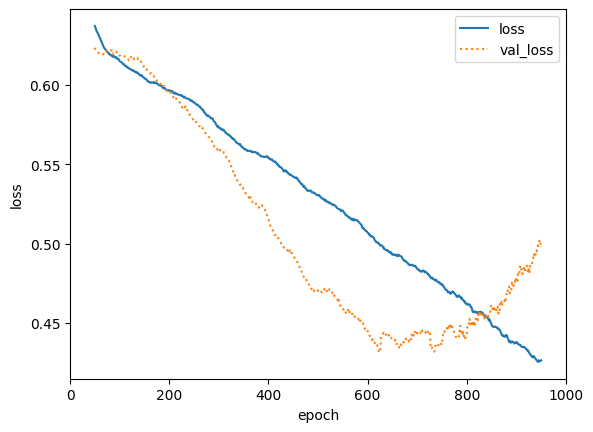

In [31]:
# 移動平均のウィンドウサイズ
factor = 100
offset = factor // 2

# 誤差のグラフ化
loss = history.history['loss']
loss = np.convolve(loss, np.ones(factor), mode='valid') / factor
val_loss = history.history['val_loss']
val_loss = np.convolve(val_loss, np.ones(factor), mode='valid') / factor

plt.plot(range(offset, len(loss)+offset), loss, label='loss')
plt.plot(range(offset, len(val_loss)+offset), val_loss, linestyle=':', label='val_loss')
plt.xlim([0, epoch])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

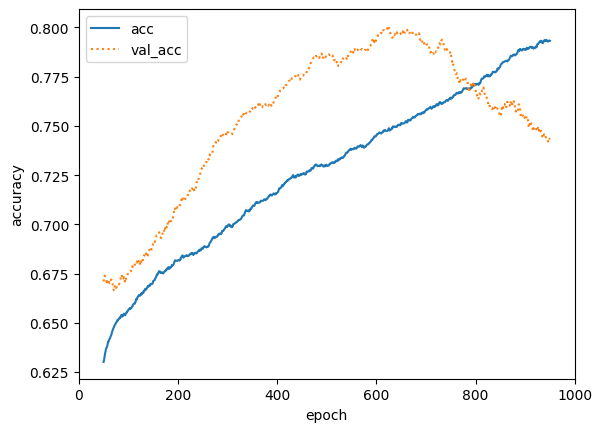

In [32]:
# 正解率のグラフ化
acc = history.history['accuracy']
acc = np.convolve(acc, np.ones(factor), mode='valid') / factor
val_acc = history.history['val_accuracy']
val_acc = np.convolve(val_acc, np.ones(factor), mode='valid') / factor

plt.plot(range(offset, len(acc)+offset), acc, label='acc')
plt.plot(range(offset, len(val_acc)+offset), val_acc, linestyle=':', label='val_acc')
plt.xlim([0, epoch])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()